In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import torch
import pytorch_lightning as pl
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from pytorch_lightning.loggers import TensorBoardLogger
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
from NFconstants import N_nod, Beta, a, K_nod
from transforms import t_get_O
from transforms import get_split_masks
from transforms import get_pair_split_masks
from transforms import config_RG_masks
from Data import MY_Dataset

normal_dist=torch.distributions.Normal(loc=torch.zeros(N_nod), scale=torch.ones(N_nod))
DS=MY_Dataset(normal_dist,N_nod)
train_loader = DataLoader(DS, batch_size=2**6, shuffle=True)

def set_random_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)

set_random_seed(42)

from flows.NormalizingFlow import NormalizingFlow    
from flows.RGflows import RGflows    
from obs import G, calc_Loss, calc_psi2, gen_fun_W




In [7]:
from setup import osc, anh, morse, tw, columb, rel_osc, rel_morse, rel_tw, rel_columb, ur 

In [9]:
class Pipeline(pl.LightningModule):
    def __init__(
        self,
        model,
        criterion,
        optimizer_class=torch.optim.Adam,
        optimizer_kwargs={"lr": 0.001,"weight_decay": 0}
    ) -> None:
        super().__init__()
        self.model = model
        self.loss = criterion
        self.optimizer_class = optimizer_class
        self.optimizer_kwargs = optimizer_kwargs

    """
    def configure_optimizers(self):
        optimizer = self.optimizer_class(
            self.model.parameters(), **self.optimizer_kwargs
        )
        return optimizer
    """
    
    def configure_optimizers(self):
        optimizer = self.optimizer_class(self.model.parameters(), **self.optimizer_kwargs)
        
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer=optimizer,
            min_lr=1e-4,
            factor=0.99,
            mode="min",
            verbose=True,
        )

        lr_scheduler = {
            "scheduler": scheduler,
            "interval": "epoch",
            "monitor": "train_loss",
        }
        return [optimizer], [lr_scheduler]

    def training_step(self, batch, batch_idx):
        z = batch
        x, log_abs_det = self.model.g(z)
        loss = self.loss(x,log_abs_det)
        sch = self.lr_schedulers()
        sch.step(loss)
        self.log('train_loss', loss,prog_bar=True)
        self.log('lr',sch.get_last_lr()[0],prog_bar=True)
        #print(loss)
        return loss


    def on_train_epoch_end(self):
        #print("---------------------------end epoch---------------------------------")
        pass
    
    def on_validation_end(self) -> None:
        if not self.automatic_optimization:
            # Save a checkpoint of the model
            ckpt_path = os.path.join(self.trainer.log_dir, 'checkpoints', 'ckpt.pt')
            self.trainer.save_checkpoint(ckpt_path, weights_only=True)
        return super().on_validation_end()
    
    

In [11]:
hidden_dim_dict1={8:8,16:16,32:32,64:64,128:128}
n_flows_dict1={8:6,16:8,32:10,64:10,128:10}
num_hidden_dict1={8:4,16:5,32:6,64:6,128:6}

In [13]:
m=3
RGmasks=config_RG_masks(m,N_nod)

In [ ]:
set_random_seed(42)
rg = RGflows.configure_RG_model(RGmasks,n_flows_dict1,num_hidden_dict1,hidden_dim_dict1,grids_no_grad=0,p_drop=0.1)
rg.save("./weights/model_weights_ur.pth")
#print(rg)

In [10]:
set_random_seed(42)
rg = RGflows.load_model("./weights/model_weights_ur.pth")
print(rg.p_drop)
#d = 3
#dim = 2**(m+d)
#rg.gr_ng = d
#rg.set_out_dim(dim)
pipeline=Pipeline(model=rg,criterion = ur.get_KL(), optimizer_class=torch.optim.Adam,optimizer_kwargs={"lr": 0.001})

trainer = pl.Trainer(
    max_epochs=200,
    logger = TensorBoardLogger(save_dir=f"./logs/nf"),
    num_sanity_val_steps=0,
    log_every_n_steps=1,
    enable_checkpointing=False,
    accumulate_grad_batches=4
)

trainer.fit(model=pipeline, train_dataloaders=train_loader)
rg.save("./weights/model_weights_ur.pth")

0.1


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\SEVA1\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "

  | Name  | Type      | Params | Mode 
--------------------------------------------
0 | model | RGflows   | 116 K  | train
1 | loss  | KL_with_S | 0      | train
--------------------------------------------
116 K     Trainable params
0         Non-trainable params
116 K     Total params
0.468     Total estimated model params size (MB)
C:\Users\SEVA1\anaconda3\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve 

Training: |                                                                                      | 0/? [00:00<…

C:\Users\SEVA1\anaconda3\Lib\site-packages\pytorch_lightning\trainer\call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


In [15]:
import numpy as np
from NFconstants import N_traj
#d = 5
#dim = 2**(m+d)
RG_trained = RGflows.load_model("./weights/model_weights_ur.pth")
RG_trained.eval()
#RG_trained.set_out_dim(dim)
N_traj=1000
z = normal_dist.sample((N_traj,))
print(z.shape)
trajs,_ = RG_trained.g(z)


torch.Size([1000, 64])


In [17]:
g_nf=G(trajs)

100%|█████████████████████████████████████████████████████████████████████████████████| 64/64 [00:00<00:00, 478.88it/s]


In [19]:
tr=np.genfromtxt("./trajs_and_corr/trajs.txt")
tr=torch.tensor(tr).float()

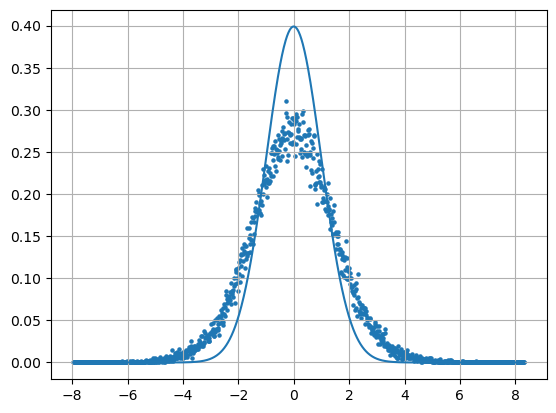

In [21]:
z,_=RG_trained.f(tr)
y, P = calc_psi2(z)
fig=plt.figure()
plt.scatter(y,P,s=5)
plt.plot(y,np.exp(-y**2/2)/(6.28)**0.5)
plt.grid(True)
plt.show()

In [23]:
from systems.Nonrel.osc_andist import calc_G
from NFconstants import N_nod, N_traj, NG_points,Beta
g_osc=calc_G(N_nod,Beta,N_nod)


In [25]:
g_ur = np.genfromtxt("./trajs_and_corr/g_ur N=256 Beta=16")

0.383556396484375


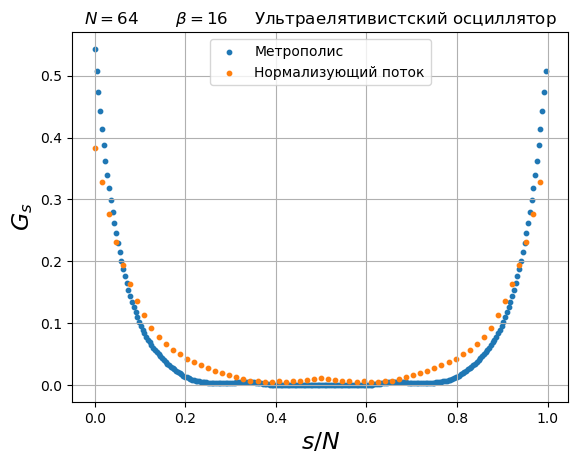

In [27]:
#import sys
#sys.path.append('../')
import numpy as np
import matplotlib.pyplot as plt
from NFconstants import N_nod, N_traj, NG_points,Beta




g=g_ur
print(g_nf[0])
MCMC_list=np.arange(len(g))/len(g)
NF_list=np.arange(len(g_nf))/len(g_nf)

fig=plt.figure()
plt.scatter(MCMC_list,g,s=10)
plt.scatter(NF_list,g_nf,s=10)
plt.legend(["Метрополис","Нормализующий поток"])
plt.title(r"$N=$"+str(N_nod)+"       "r"$\beta=$"+str(Beta)+"     Ультраелятивистский осциллятор")
plt.ylabel(r"$G_s$",fontsize=17)
plt.xlabel(r"$s/N$",fontsize=17)
#plt.yscale("log")
plt.grid(True)
plt.show()
